In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#ee6611; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Settings')

In [3]:
import os,numpy as np,pandas as pd
import pylab as pl,seaborn as sn,tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image as kimg
from tqdm import tqdm
from IPython.core.magic import register_line_magic
import tensorflow_hub as th
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from PIL import ImageFile

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES=True
img_size,img_size2=32,96
classes=['plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck']
manners=['pictogram','contour','sketch']
objects=['flower','bird','butterfly','tree',
         'plane','crane','dog','horse',
         'deer','truck','car','cat',
         'frog','ship','fish','house']
fpath='../input/art-pictogram/pictograms/'
flist=sorted(os.listdir(fpath))
fw='weights.best.hdf5'
history,model=[],[]
x_train,rx_train,y_train,\
x_test,rx_test,y_test,\
x_valid,rx_valid,y_valid=\
[],[],[],[],[],[],[],[],[]

In [5]:
def img_resize(x):
    global img_size2        
    x=tf.image.resize(x,[img_size2,img_size2])
    return x.numpy()

In [6]:
dhtml('NN Models')

In [7]:
@register_line_magic
def cnn_model(n):
    global history,model,img_size,\
    x_train,y_train,x_test,y_test,x_valid,y_valid
    if n=='1': 
        x_train,y_train=x_train1,y_train1
        x_valid,y_valid=x_valid1,y_valid1
    if n=='2': 
        x_train,y_train=x_train2,y_train2
        x_valid,y_valid=x_valid2,y_valid2
    model=Sequential()
    model.add(tkl.Conv2D(32,(5,5),padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(tkl.Activation('relu'))
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(196,(5,5)))
    model.add(tkl.Activation('relu'))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.GlobalAveragePooling2D())    
    model.add(tkl.Dense(1024,activation='relu'))
    model.add(tkl.Dropout(.5))         
    model.add(tkl.Dense(10))
    model.add(tkl.Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                     patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=2,
                                     save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                       patience=5,factor=.8)
    history=model.fit(x_train,y_train,epochs=100,
                      batch_size=64,verbose=2,
                      validation_data=(x_valid,y_valid),
                      callbacks=[checkpointer,
                                 early_stopping,
                                 lr_reduction])

In [8]:
@register_line_magic
def hub_model(n):
    global history,model,img_size2,\
    rx_train,y_train,rx_test,y_test,rx_valid,y_valid
    if n=='1': 
        rx_train,y_train=rx_train1,y_train1
        rx_valid,y_valid=rx_valid1,y_valid1
    if n=='2': 
        rx_train,y_train=rx_train2,y_train2
        rx_valid,y_valid=rx_valid2,y_valid2
    handle_base="mobilenet_v2_050_96"
    mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
    .format(handle_base)
    model=tf.keras.Sequential([
        tf.keras.layers.Input((img_size2,img_size2,3),
                              name='input'),
        th.KerasLayer(mhandle,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(10,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy') 
    early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                     patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=2,
                                     save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                       patience=5,factor=.8)
    history=model.fit(rx_train,y_train,epochs=50,
                      batch_size=64,verbose=2,
                      validation_data=(rx_valid,y_valid),
                      callbacks=[checkpointer,
                                 early_stopping,
                                 lr_reduction])

In [9]:
def history_plot(fit_history):
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#ee6611',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#ee6611',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

In [10]:
dhtml('Pictogram Data')

In [11]:
def path_to_tensor(img_path,fpath):
    img=kimg.load_img(fpath+img_path,
                      target_size=(img_size,img_size))
    x=kimg.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath):
    tensor_list=[path_to_tensor(img_path,fpath) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
labels1=np.array([int(el[:2]) for el in flist],
                 dtype='int8')-1
labels2=np.array([int(el[3:6]) for el in flist],
                 dtype='int8')-1
images=np.array(paths_to_tensor(flist,fpath=fpath))/255
n2=len(labels1[labels1==0])
images=images[:n2]; labels2=labels2[:n2]
cond=np.where([l in classes for l in objects])[0]
cond2=np.where([l in cond for l in labels2])
x=images[cond2]; y=labels2[cond2]
rd={1:2,4:0,6:5,7:7,8:4,9:9,10:1,11:3,12:6,13:8}
y=np.array([rd.get(el,el) for el in y],
            dtype='int8')
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(123).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test1,x_valid1,x_train1=x[:n],x[n:2*n],x[2*n:]
y_test1,y_valid1,y_train1=y[:n],y[n:2*n],y[2*n:]

100%|██████████| 3143/3143 [00:17<00:00, 181.26it/s]


[(1102, 32, 32, 3), dtype('float32'), (1102,), dtype('int8')]
Label:  dog


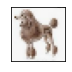

In [12]:
print([x.shape,x.dtype,y.shape,y.dtype])
print('Label: ',classes[y[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(x[100]);

In [13]:
%cnn_model 1

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.29458, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.3074 - accuracy: 0.1043 - val_loss: 2.2946 - val_accuracy: 0.1091
Epoch 2/100

Epoch 00002: val_loss improved from 2.29458 to 2.29449, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2930 - accuracy: 0.1259 - val_loss: 2.2945 - val_accuracy: 0.1091
Epoch 3/100

Epoch 00003: val_loss improved from 2.29449 to 2.28894, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2898 - accuracy: 0.1100 - val_loss: 2.2889 - val_accuracy: 0.1636
Epoch 4/100

Epoch 00004: val_loss improved from 2.28894 to 2.26234, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2727 - accuracy: 0.1576 - val_loss: 2.2623 - val_accuracy: 0.2000
Epoch 5/100

Epoch 00005: val_loss improved from 2.26234 to 2.18906, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2341 - accuracy: 0.1791 - val_loss: 2.1891 - val_accuracy: 0.2091
Epoch 6/100

Epoch 00006: val_loss improved from 2.189

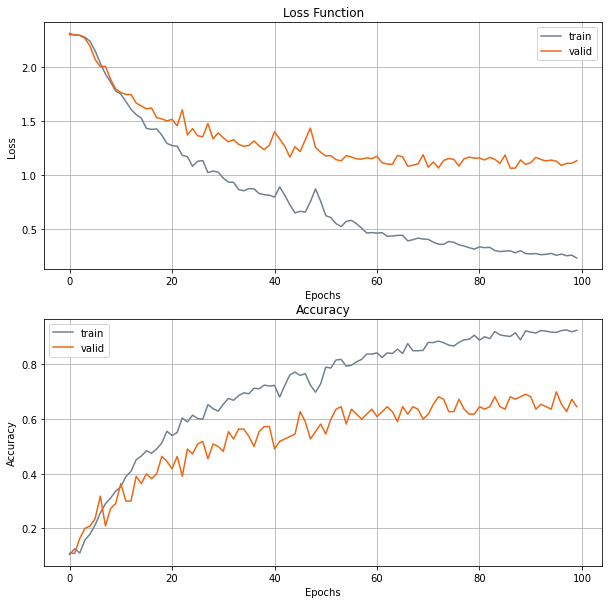

In [14]:
history_plot(history)

In [15]:
model.load_weights(fw)
model.evaluate(x_test1,y_test1)

4/4 [==============================] - 0s 4ms/step - loss: 1.3010 - accuracy: 0.6455


[1.3009792566299438, 0.6454545259475708]

[(882, 96, 96, 3), dtype('float32')]
Label:  dog


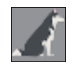

In [16]:
rx_train1,rx_test1,rx_valid1=\
img_resize(x_train1),img_resize(x_test1),img_resize(x_valid1)
print([rx_train1.shape,rx_train1.dtype])
print('Label: ',classes[y_valid1[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(rx_valid1[100]);

In [17]:
%hub_model 1

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.24477, saving model to weights.best.hdf5
14/14 - 2s - loss: 1.3877 - accuracy: 0.5828 - val_loss: 1.2448 - val_accuracy: 0.6727
Epoch 2/50

Epoch 00002: val_loss did not improve from 1.24477
14/14 - 1s - loss: 0.3971 - accuracy: 0.8832 - val_loss: 1.3099 - val_accuracy: 0.7091
Epoch 3/50

Epoch 00003: val_loss did not improve from 1.24477
14/14 - 1s - loss: 0.2434 - accuracy: 0.9422 - val_loss: 2.0535 - val_accuracy: 0.6818
Epoch 4/50

Epoch 00004: val_loss did not improve from 1.24477
14/14 - 1s - loss: 0.1843 - accuracy: 0.9558 - val_loss: 1.9183 - val_accuracy: 0.7273
Epoch 5/50

Epoch 00005: val_loss did not improve from 1.24477
14/14 - 1s - loss: 0.1664 - accuracy: 0.9615 - val_loss: 2.9154 - val_accuracy: 0.6182
Epoch 6/50

Epoch 00006: val_loss did not improve from 1.24477

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
14/14 - 1s - loss: 0.2176 - accuracy: 0.9569 - val_loss: 4.6009 - val_ac

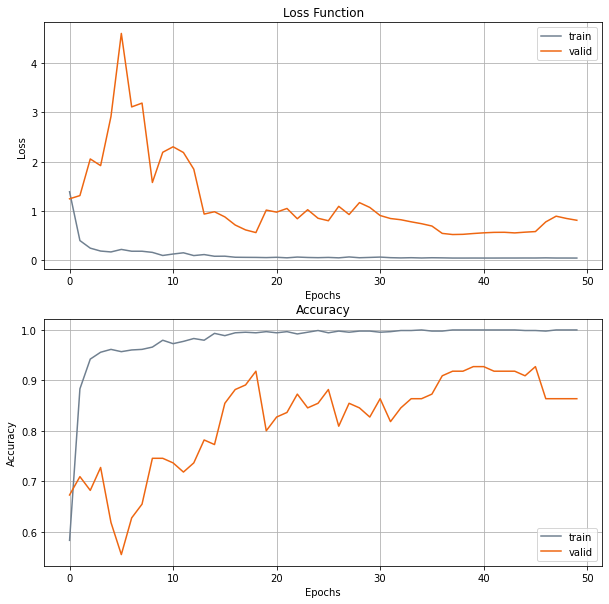

In [18]:
history_plot(history)

In [19]:
model.load_weights(fw)
model.evaluate(rx_test1,y_test1)

4/4 [==============================] - 0s 21ms/step - loss: 0.8768 - accuracy: 0.8273


[0.8767823576927185, 0.8272727131843567]

In [20]:
dhtml('CIFAR Data')

In [21]:
(x,y),(_,_)=cifar10.load_data()
x2=np.array(x,dtype='float32')/255
y2=y.reshape(-1)
N2=len(y2); n2=int(.1*N2)
shuffle_ids2=np.arange(N2)
np.random.RandomState(234).shuffle(shuffle_ids2)
shuffle_ids2=shuffle_ids2[:N]
x2,y2=x2[shuffle_ids2],y2[shuffle_ids2]
x_test2,x_valid2,x_train2=x2[:n],x2[n:2*n],x2[2*n:]
y_test2,y_valid2,y_train2=y2[:n],y2[n:2*n],y2[2*n:]

170500096/170498071 [==============================] - 7s 0us/step


[(1102, 32, 32, 3), dtype('float32'), (1102,), dtype('uint8')]
Label:  truck


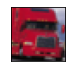

In [22]:
print([x2.shape,x2.dtype,y2.shape,y2.dtype])
print('Label: ',classes[y2[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(x2[100]);

In [23]:
%cnn_model 2

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.29453, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.3121 - accuracy: 0.1088 - val_loss: 2.2945 - val_accuracy: 0.1636
Epoch 2/100

Epoch 00002: val_loss improved from 2.29453 to 2.23004, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.2709 - accuracy: 0.1757 - val_loss: 2.2300 - val_accuracy: 0.1818
Epoch 3/100

Epoch 00003: val_loss improved from 2.23004 to 2.13223, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.1856 - accuracy: 0.1882 - val_loss: 2.1322 - val_accuracy: 0.1818
Epoch 4/100

Epoch 00004: val_loss did not improve from 2.13223
14/14 - 0s - loss: 2.2114 - accuracy: 0.1735 - val_loss: 2.1464 - val_accuracy: 0.2091
Epoch 5/100

Epoch 00005: val_loss improved from 2.13223 to 2.09830, saving model to weights.best.hdf5
14/14 - 0s - loss: 2.1363 - accuracy: 0.2029 - val_loss: 2.0983 - val_accuracy: 0.2000
Epoch 6/100

Epoch 00006: val_loss improved from 2.09830 to 2.08574, saving model to weights.

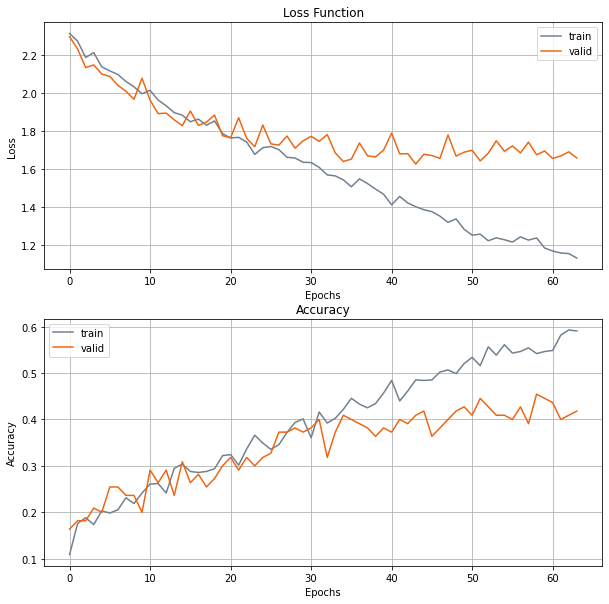

In [24]:
history_plot(history)

In [25]:
model.load_weights(fw)
model.evaluate(x_test2,y_test2)

4/4 [==============================] - 0s 2ms/step - loss: 1.5166 - accuracy: 0.4364


[1.5165940523147583, 0.4363636374473572]

[(882, 32, 32, 3), dtype('float32')]
Label:  plane


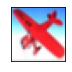

In [26]:
rx_train2,rx_test2,rx_valid2=\
img_resize(x_train2),img_resize(x_test2),img_resize(x_valid2)
print([x_train2.shape,x_train2.dtype])
print('Label: ',classes[y_valid2[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(x_valid2[100]);

In [27]:
%hub_model 2

Epoch 1/50

Epoch 00001: val_loss improved from inf to 2.03955, saving model to weights.best.hdf5
14/14 - 2s - loss: 1.5222 - accuracy: 0.5272 - val_loss: 2.0395 - val_accuracy: 0.4818
Epoch 2/50

Epoch 00002: val_loss did not improve from 2.03955
14/14 - 1s - loss: 0.6009 - accuracy: 0.8322 - val_loss: 3.9845 - val_accuracy: 0.3636
Epoch 3/50

Epoch 00003: val_loss did not improve from 2.03955
14/14 - 1s - loss: 0.3027 - accuracy: 0.9082 - val_loss: 3.2643 - val_accuracy: 0.4364
Epoch 4/50

Epoch 00004: val_loss did not improve from 2.03955
14/14 - 1s - loss: 0.1893 - accuracy: 0.9546 - val_loss: 2.3958 - val_accuracy: 0.5636
Epoch 5/50

Epoch 00005: val_loss did not improve from 2.03955
14/14 - 1s - loss: 0.1399 - accuracy: 0.9739 - val_loss: 3.4437 - val_accuracy: 0.5182
Epoch 6/50

Epoch 00006: val_loss did not improve from 2.03955

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
14/14 - 1s - loss: 0.1337 - accuracy: 0.9671 - val_loss: 3.5510 - val_ac

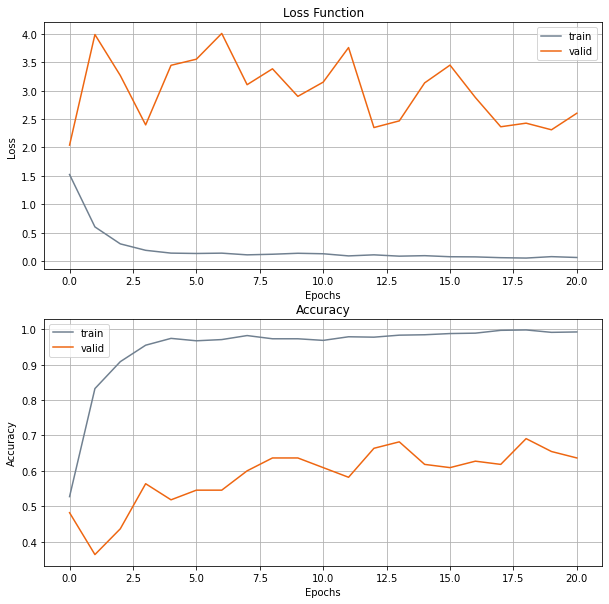

In [28]:
history_plot(history)

In [29]:
model.load_weights(fw)
model.evaluate(rx_test2,y_test2)

4/4 [==============================] - 0s 6ms/step - loss: 1.9713 - accuracy: 0.5182


[1.9712762832641602, 0.5181818008422852]

In [30]:
dhtml('Mixed Data')

In [31]:
x_train=np.vstack([x_train1,x_train2])
x_test=np.vstack([x_test1,x_test2])
x_valid=np.vstack([x_valid1,x_valid2])
y_train=np.hstack([y_train1,y_train2])
y_test=np.hstack([y_test1,y_test2])
y_valid=np.hstack([y_valid1,y_valid2])
for [x,y] in [[x_train,y_train],
              [x_test,y_test],
              [x_valid,y_valid]]:
    N=len(y); shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x,y=x[shuffle_ids],y[shuffle_ids]
    print([x.shape,x.dtype,y.shape,y.dtype])

[(1764, 32, 32, 3), dtype('float32'), (1764,), dtype('int16')]
[(220, 32, 32, 3), dtype('float32'), (220,), dtype('int16')]
[(220, 32, 32, 3), dtype('float32'), (220,), dtype('int16')]


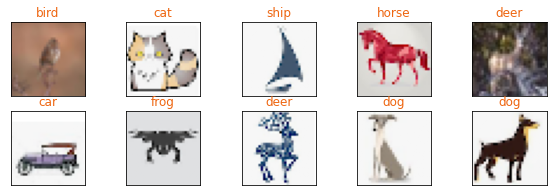

In [32]:
fig=pl.figure(figsize=(10,3))
randch=np.random.choice(x_test.shape[0],
                        size=10,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,5,i+1,
                       xticks=[],yticks=[])
    ax.imshow(x_test[idx])
    true_idx=y_test[idx]
    ax.set_title(classes[true_idx],color="#ee6611")

In [33]:
%cnn_model 0

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.30085, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.3112 - accuracy: 0.1026 - val_loss: 2.3009 - val_accuracy: 0.1000
Epoch 2/100

Epoch 00002: val_loss improved from 2.30085 to 2.26957, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.2951 - accuracy: 0.1151 - val_loss: 2.2696 - val_accuracy: 0.1773
Epoch 3/100

Epoch 00003: val_loss improved from 2.26957 to 2.23608, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.2595 - accuracy: 0.1446 - val_loss: 2.2361 - val_accuracy: 0.1591
Epoch 4/100

Epoch 00004: val_loss improved from 2.23608 to 2.10406, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.2055 - accuracy: 0.1735 - val_loss: 2.1041 - val_accuracy: 0.2318
Epoch 5/100

Epoch 00005: val_loss improved from 2.10406 to 1.96932, saving model to weights.best.hdf5
28/28 - 0s - loss: 2.0847 - accuracy: 0.2092 - val_loss: 1.9693 - val_accuracy: 0.2409
Epoch 6/100

Epoch 00006: val_loss did not improve fro

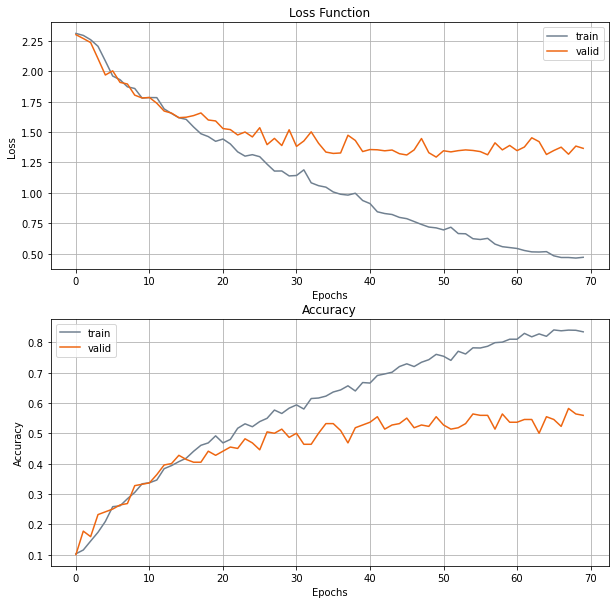

In [34]:
history_plot(history)

In [35]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 3ms/step - loss: 1.3097 - accuracy: 0.5455


[1.3097257614135742, 0.5454545617103577]

In [36]:
rx_train=np.vstack([rx_train1,rx_train2])
rx_test=np.vstack([rx_test1,rx_test2])
rx_valid=np.vstack([rx_valid1,rx_valid2])
y_train=np.hstack([y_train1,y_train2])
y_test=np.hstack([y_test1,y_test2])
y_valid=np.hstack([y_valid1,y_valid2])
for [x,y] in [[rx_train,y_train],
              [rx_test,y_test],
              [rx_valid,y_valid]]:
    N=len(y); shuffle_ids=np.arange(N)
    np.random.RandomState(23).shuffle(shuffle_ids)
    x,y=x[shuffle_ids],y[shuffle_ids]
    print([x.shape,x.dtype,y.shape,y.dtype])

[(1764, 96, 96, 3), dtype('float32'), (1764,), dtype('int16')]
[(220, 96, 96, 3), dtype('float32'), (220,), dtype('int16')]
[(220, 96, 96, 3), dtype('float32'), (220,), dtype('int16')]


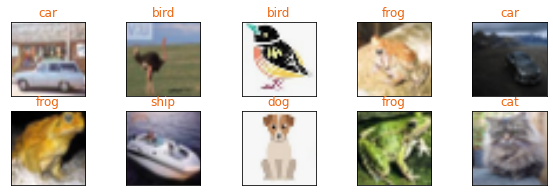

In [37]:
fig=pl.figure(figsize=(10,3))
randch=np.random.choice(rx_test.shape[0],
                        size=10,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,5,i+1,
                       xticks=[],yticks=[])
    ax.imshow(rx_test[idx])
    true_idx=y_test[idx]
    ax.set_title(classes[true_idx],color="#ee6611")

In [38]:
%hub_model 0

Epoch 1/50

Epoch 00001: val_loss improved from inf to 2.03533, saving model to weights.best.hdf5
28/28 - 3s - loss: 1.4041 - accuracy: 0.5964 - val_loss: 2.0353 - val_accuracy: 0.5409
Epoch 2/50

Epoch 00002: val_loss improved from 2.03533 to 1.30376, saving model to weights.best.hdf5
28/28 - 2s - loss: 0.5622 - accuracy: 0.8328 - val_loss: 1.3038 - val_accuracy: 0.6545
Epoch 3/50

Epoch 00003: val_loss did not improve from 1.30376
28/28 - 1s - loss: 0.3706 - accuracy: 0.8957 - val_loss: 2.7280 - val_accuracy: 0.5955
Epoch 4/50

Epoch 00004: val_loss did not improve from 1.30376
28/28 - 1s - loss: 0.3216 - accuracy: 0.9178 - val_loss: 2.0064 - val_accuracy: 0.6773
Epoch 5/50

Epoch 00005: val_loss did not improve from 1.30376
28/28 - 1s - loss: 0.2760 - accuracy: 0.9263 - val_loss: 1.7290 - val_accuracy: 0.7182
Epoch 6/50

Epoch 00006: val_loss did not improve from 1.30376
28/28 - 1s - loss: 0.2772 - accuracy: 0.9303 - val_loss: 1.8009 - val_accuracy: 0.6864
Epoch 7/50

Epoch 00007: v

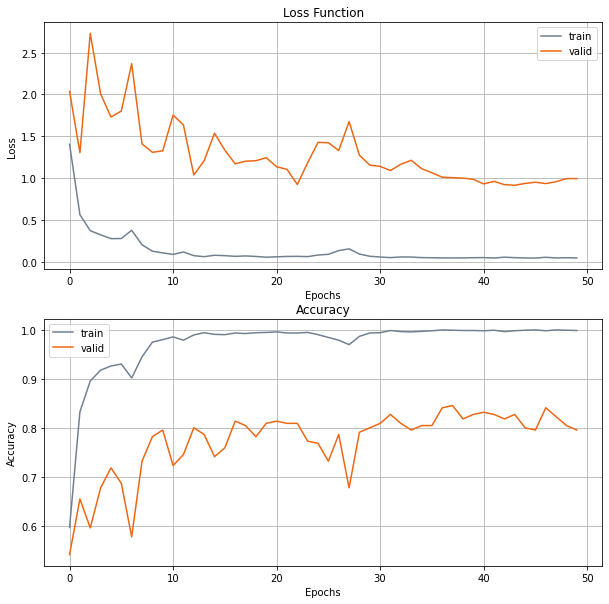

In [39]:
history_plot(history)

In [40]:
model.load_weights(fw)
model.evaluate(rx_test,y_test)

7/7 [==============================] - 0s 6ms/step - loss: 0.9064 - accuracy: 0.8182


[0.9064304232597351, 0.8181818127632141]